# create a 12 minute timeseries distance of pleiades from earth

In [1]:
import numpy as np
import pandas as pd
from astropy.time import Time
from astropy.coordinates import get_body, SkyCoord, solar_system_ephemeris
import astropy.units as u

# Define date range (1 year, daily)
dates = Time(np.arange("2025-01-01", "2026-01-01", dtype="datetime64[D]"))

# --- Fetch Earth Positions ---
earth_x, earth_y, earth_z = [], [], []

with solar_system_ephemeris.set("jpl"):
    for date in dates:
        earth = get_body("earth", date)
        earth_x.append(earth.cartesian.x.to(u.AU).value)
        earth_y.append(earth.cartesian.y.to(u.AU).value)
        earth_z.append(earth.cartesian.z.to(u.AU).value)

# Save Earth data
earth_df = pd.DataFrame({"date": dates.iso, "x": earth_x, "y": earth_y, "z": earth_z})
earth_df.to_csv("./data/earth_positions.csv", index=False)

# --- Convert Pleiades RA/Dec to Cartesian ---
pleiades_stars = {
    "Alcyone": SkyCoord("03h47m29.1s", "+24d06m18s", distance=136 * u.pc, frame="icrs")
}

pleiades_data = []

for star_name, star_coord in pleiades_stars.items():
    pleiades_df = pd.DataFrame({
        "date": dates.iso,
        "x": np.full(len(dates), star_coord.cartesian.x.to(u.AU).value),
        "y": np.full(len(dates), star_coord.cartesian.y.to(u.AU).value),
        "z": np.full(len(dates), star_coord.cartesian.z.to(u.AU).value),
        "star_id": star_name
    })
    pleiades_data.append(pleiades_df)

# Combine Pleiades star data
pleiades_df = pd.concat(pleiades_data)
pleiades_df.to_csv("./data/pleiades_positions.csv", index=False)

print("Generated earth_positions.csv and pleiades_positions.csv using Astropy.")


Generated earth_positions.csv and pleiades_positions.csv using Astropy.


In [2]:
from astropy.time import Time
from astropy.coordinates import get_body_barycentric
import pandas as pd
import numpy as np

# Define start and end dates for the year
start_date = Time('2025-01-01', format='iso')
end_date = Time('2025-12-31', format='iso')

# Create an array of times spanning the year, one per day
num_days = (end_date - start_date).value + 1
dates = start_date + np.arange(num_days)

# Calculate Earth's position for each date
positions = get_body_barycentric("earth", dates)

# Extract x, y, z components in AU
earth_x = positions.x.to('AU').value
earth_y = positions.y.to('AU').value
earth_z = positions.z.to('AU').value

# Create DataFrame
earth_df = pd.DataFrame({
    "date": dates.iso,
    "x": earth_x,
    "y": earth_y,
    "z": earth_z
})

# Save to CSV
earth_df.to_csv(".\data\earth_positions_2024.csv", index=False)

print("Saved Earth positions for 2024 in 'earth_positions_2024.csv'")


Saved Earth positions for 2024 in 'earth_positions_2024.csv'


<>:31: SyntaxWarning: "\d" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\d"? A raw string is also an option.
<>:31: SyntaxWarning: "\d" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\d"? A raw string is also an option.
C:\Users\clwhit13\AppData\Local\Temp\1\ipykernel_10548\1024844739.py:31: SyntaxWarning: "\d" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\d"? A raw string is also an option.
  earth_df.to_csv(".\data\earth_positions_2024.csv", index=False)


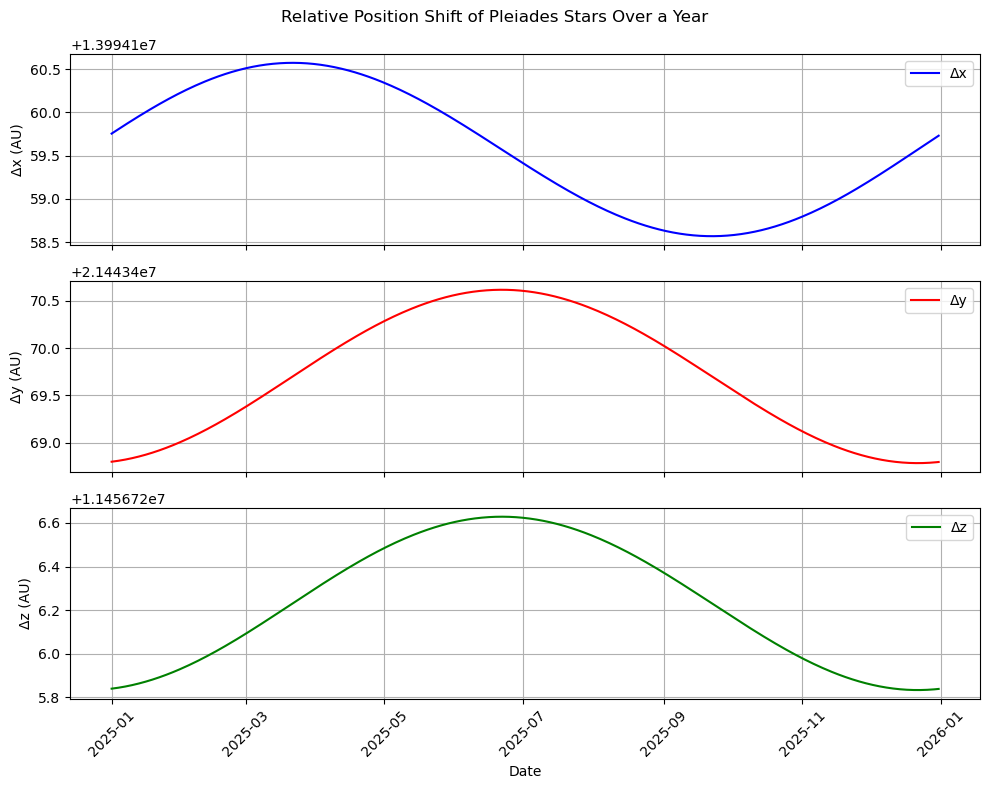

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data (replace with actual file paths)
pleiades_df = pd.read_csv("./data/pleiades_positions.csv")  # Contains x, y, z for stars over time
earth_df = pd.read_csv("./data/earth_positions_2024.csv")  # Contains x, y, z for Earth over time

# Ensure dates are in datetime format
pleiades_df["date"] = pd.to_datetime(pleiades_df["date"])
earth_df["date"] = pd.to_datetime(earth_df["date"])

# Merge data on the date column
data = pd.merge(pleiades_df, earth_df, on="date", suffixes=("_star", "_earth"))

# Compute the difference in positions (relative shift)
data["dx"] = data["x_star"] - data["x_earth"]
data["dy"] = data["y_star"] - data["y_earth"]
data["dz"] = data["z_star"] - data["z_earth"]

# Plot the relative shifts over time
fig, ax = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

ax[0].plot(data["date"], data["dx"], label="Δx", color="blue")
ax[1].plot(data["date"], data["dy"], label="Δy", color="red")
ax[2].plot(data["date"], data["dz"], label="Δz", color="green")

# Labels and formatting
ax[0].set_ylabel("Δx (AU)")
ax[1].set_ylabel("Δy (AU)")
ax[2].set_ylabel("Δz (AU)")
ax[2].set_xlabel("Date")

for a in ax:
    a.legend()
    a.grid()

plt.suptitle("Relative Position Shift of Pleiades Stars Over a Year")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("timeseries_pleiades.png", dpi=300, bbox_inches="tight")
plt.show()


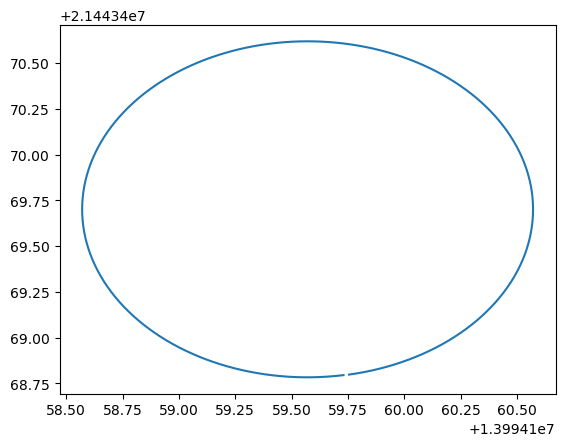

In [4]:
plt.plot(data["dx"],data["dy"])

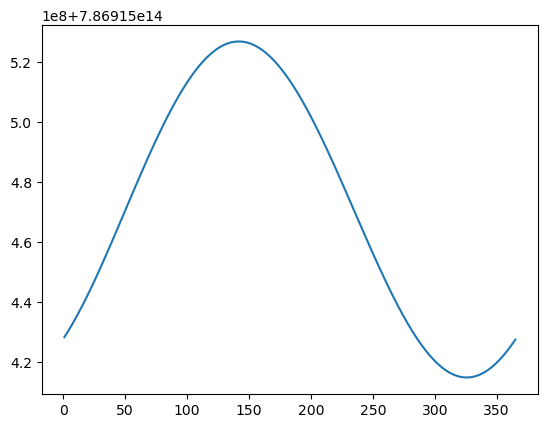

In [5]:
#data["x_star"] - data["x_earth"]
ts = data["dx"]**2+data["dy"]**2+data["dz"]**2
x = np.arange(1,366)
plt.plot(x,ts)
#plt.plot(data["x_earth"]**2+data["y_earth"]**2+data["z_earth"]**2)
#plt.plot(data["x_star"]**2+data["y_star"]**2+data["z_star"]**2)

In [6]:
# New index for interpolation (7200 points)
new_index = np.linspace(0, 364, 7200)  # Using 0-based index to match DataFrame
# Generate 7200 evenly spaced timestamps
date_array = pd.date_range(start=data.date[0], end=data.date[364], periods=7200)

# Perform interpolation
df_interpolated = pd.DataFrame(index=new_index)
df_interpolated['date']=date_array
for column in data.columns:
    if np.issubdtype(data[column].dtype, np.number):  # Check if column is numeric
        df_interpolated[column] = np.interp(new_index, np.arange(365), data[column])


In [7]:
df_interpolated

,date,x_star,y_star,z_star,x_earth,y_earth,z_earth,dx,dy,dz
0.000000,2025-01-01 00:00:00.000000000,1.399416e+07,2.144347e+07,1.145673e+07,-0.184427,0.882631,0.382807,1.399416e+07,2.144347e+07,1.145673e+07
0.050563,2025-01-01 01:12:48.606750937,1.399416e+07,2.144347e+07,1.145673e+07,-0.185295,0.882476,0.382740,1.399416e+07,2.144347e+07,1.145673e+07
0.101125,2025-01-01 02:25:37.213501875,1.399416e+07,2.144347e+07,1.145673e+07,-0.186163,0.882320,0.382672,1.399416e+07,2.144347e+07,1.145673e+07
0.151688,2025-01-01 03:38:25.820252812,1.399416e+07,2.144347e+07,1.145673e+07,-0.187031,0.882165,0.382605,1.399416e+07,2.144347e+07,1.145673e+07
0.202250,2025-01-01 04:51:14.427003750,1.399416e+07,2.144347e+07,1.145673e+07,-0.187899,0.882010,0.382538,1.399416e+07,2.144347e+07,1.145673e+07
...,...,...,...,...,...,...,...,...,...,...
363.797750,2025-12-30 19:08:45.572996252,1.399416e+07,2.144347e+07,1.145673e+07,-0.156644,0.886011,0.384211,1.399416e+07,2.144347e+07,1.145673e+07
363.848312,2025-12-30 20:21:34.179747188,1.399416e+07,2.144347e+07,1.145673e+07,-0.157518,0.885887,0.384158,1.399416e+07,2.144347e+07,1.145673e+07
363.898875,2025-12-30 21:34:22.786498124,1.399416e+07,2.144347e+07,1.145673e+07,-0.158391,0.885763,0.384104,1.399416e+07,2.144347e+07,1.145673e+07
363.949437,2025-12-30 22:47:11.393249064,1.399416e+07,2.144347e+07,1.145673e+07,-0.159264,0.885640,0.384050,1.399416e+07,2.144347e+07,1.145673e+07
